In [55]:
import numpy as np
from tqdm import tqdm
from PIL import Image

import torch.nn as nn
from torch.autograd import Variable
import torch

import torchvision.transforms as transforms
import torchvision.models as models
import torchvision

In [56]:
transform = transforms.Compose(
            [
            # 左右対称の画像を生成してデータ量を増やす(Augmentation)
            transforms.RandomHorizontalFlip(),

            # 224*224に画像サイズを変更
            transforms.Resize((224, 224)),

            # PyTorchで利用するTensorの形式にデータを変換
            transforms.ToTensor(),

            # 画像をImageNetデータ(事前学習のデータ)に合わせる
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

            ])

train_data = torchvision.datasets.ImageFolder(root='./data/train', transform=transform)
val_data = torchvision.datasets.ImageFolder(root='./data/val', transform=transform)
test_data = torchvision.datasets.ImageFolder(root='./data/test', transform=transform)

data_size  = {"train":len(train_data), "validation":len(val_data)}

train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False)

In [57]:
model = models.resnet18(pretrained=True)
print(model)
# ネットワークの重みを固定
for parameter in model.parameters():
    parameter.requires_grad = False

# 最終的な出力を2個に設定
model.fc = nn.Linear(512, 2)

if torch.cuda.is_available():
    model.cuda()


/home/student/anaconda3/envs/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/student/anaconda3/envs/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [58]:
def show_score(epoch,max_epoch,itr,max_itr,loss,acc,is_val=False):
  print('\r{} EPOCH[{:03}/{:03}] ITR [{:04}/{:04}] LOSS:{:.05f} ACC:{:03f}'.format("VAL  " if is_val else "TRAIN",epoch,max_epoch,itr,max_itr,loss,acc*100),end = '')

def cal_acc(output,label):
  p_arg = torch.argmax(output,dim = 1)
  return torch.sum(label == p_arg)

def Train_Eval(model,criterion,optimizer,data_loader,device,epoch,max_epoch,is_val = False):
  total_loss = 0.0
  total_acc = 0.0
  counter = 0
  model.eval() if is_val else model.train()
  for n,(data,label) in enumerate(data_loader):
    counter += data.shape[0]
    optimizer.zero_grad()
    data = data.to(device)
    label = label.to(device)
    if is_val:
      with torch.no_grad():
        output = model(data)
    else:
      output = model(data)
    loss = criterion(output,label)
    total_loss += loss.item()
    total_acc += cal_acc(output,label)
    
    if is_val != True:
      loss.backward()
      optimizer.step()
    show_score(epoch+1,max_epoch,n+1,len(data_loader),total_loss/(n+1) , total_acc/counter,is_val=is_val)
  print()
  return total_loss , total_acc

In [5]:
lr=1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss().cuda()
EPOCHS = 50
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
best_loss = None

for epoch in range(EPOCHS):
  train_loss,train_acc = Train_Eval(model,criterion,optimizer,train_loader,DEVICE,epoch,EPOCHS) 
  val_loss,val_acc    = Train_Eval(model,criterion,optimizer,val_loader,DEVICE,epoch,EPOCHS,is_val=True)

  ## best_lossより小さなval_lossが出力された場合のみモデルを保存する。##
  if best_loss is None or val_loss < best_loss:
    best_loss = val_loss
    torch.save(model.state_dict(), './best_ckpt1.pth')
  #################################################################
  train_loss_list.append(train_loss)
  train_acc_list.append(train_acc)
  val_loss_list.append(val_loss)
  val_acc_list.append(val_acc)


TRAIN EPOCH[001/050] ITR [0562/0562] LOSS:0.49284 ACC:77.416481
VAL   EPOCH[001/050] ITR [0091/0091] LOSS:0.37019 ACC:83.770721
TRAIN EPOCH[002/050] ITR [0562/0562] LOSS:0.37502 ACC:84.265038
VAL   EPOCH[002/050] ITR [0091/0091] LOSS:0.33569 ACC:86.256912
TRAIN EPOCH[003/050] ITR [0562/0562] LOSS:0.34798 ACC:85.178169
VAL   EPOCH[003/050] ITR [0091/0091] LOSS:0.31266 ACC:85.635361
TRAIN EPOCH[004/050] ITR [0562/0562] LOSS:0.32704 ACC:86.737190
VAL   EPOCH[004/050] ITR [0091/0091] LOSS:0.30193 ACC:86.395035
TRAIN EPOCH[005/050] ITR [0562/0562] LOSS:0.31758 ACC:87.0378650
VAL   EPOCH[005/050] ITR [0091/0091] LOSS:0.30598 ACC:86.187851
TRAIN EPOCH[006/050] ITR [0562/0562] LOSS:0.31110 ACC:87.115814
VAL   EPOCH[006/050] ITR [0091/0091] LOSS:0.31403 ACC:87.776245
TRAIN EPOCH[007/050] ITR [0562/0562] LOSS:0.29795 ACC:87.861916
VAL   EPOCH[007/050] ITR [0091/0091] LOSS:0.29429 ACC:87.430939
TRAIN EPOCH[008/050] ITR [0562/0562] LOSS:0.29545 ACC:87.817368
VAL   EPOCH[008/050] ITR [0091/0091] LO

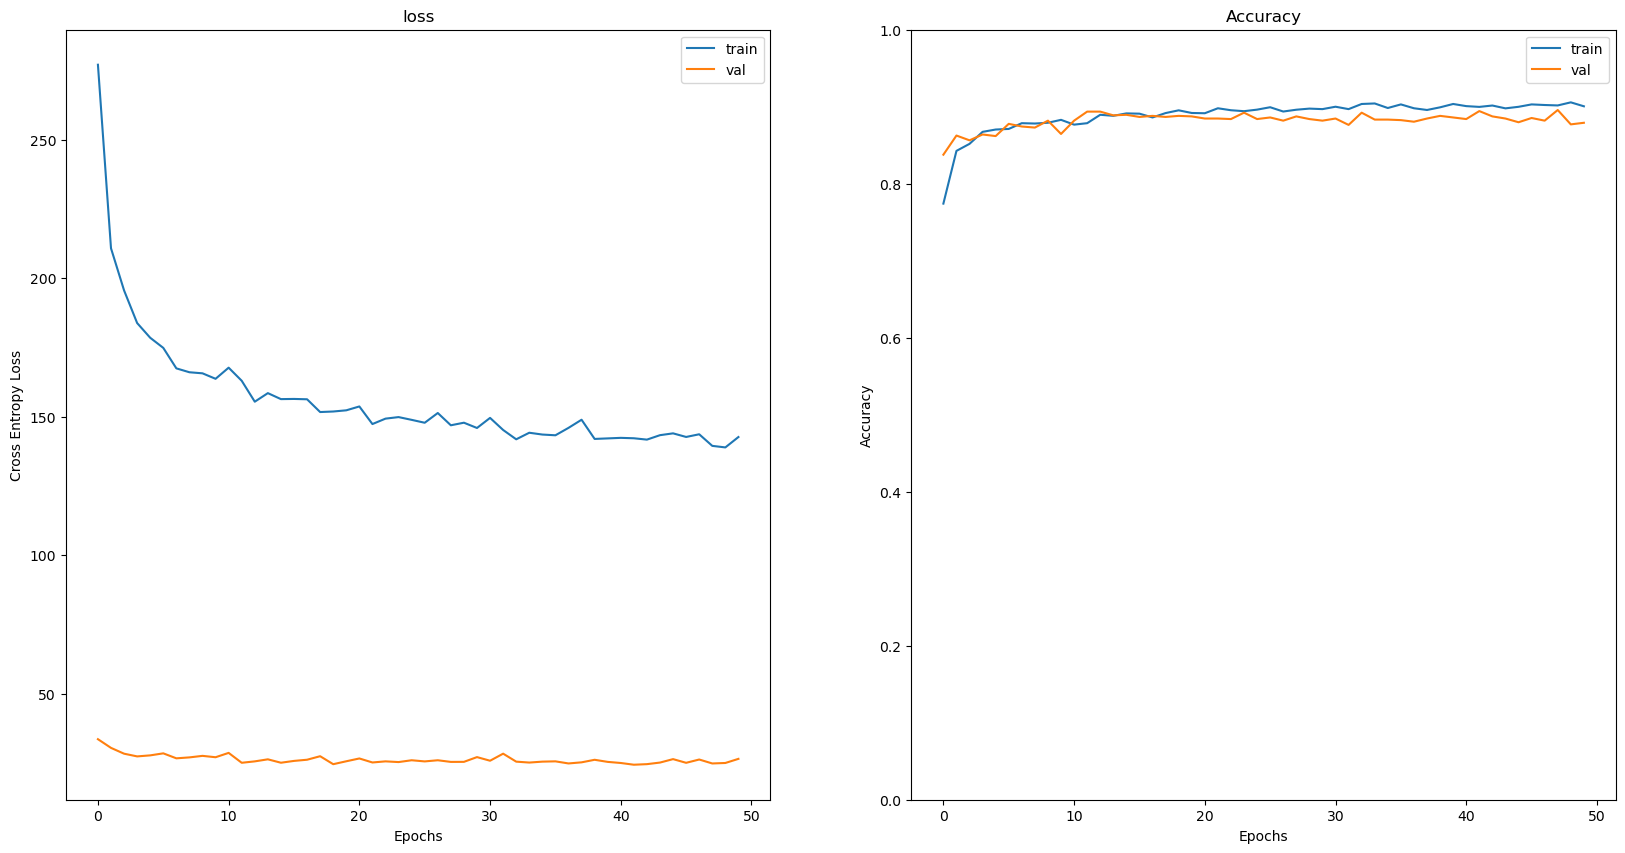

In [6]:
from matplotlib import pyplot as plt
from random import randint, random

## 描画データの準備
x = list(range(EPOCHS))
val_len = len(val_data)
train_len = len(train_data)
y1 = train_loss_list
y2 = val_loss_list

tensor_y3 = [x/train_len for x in train_acc_list]
tensor_y4 = [x/val_len for x in val_acc_list]

y3 = []
y4 = []

for acc in tensor_y3:
    acc = acc.to('cpu').detach().numpy().copy()
    y3.append(acc)

for acc in tensor_y4:
    acc = acc.to('cpu').detach().numpy().copy()
    y4.append(acc)


## 損失のグラフ描画
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1, 2, 1)

## グラフのラベル・タイトルを設定
ax.set_title("loss")
ax.set_xlabel('Epochs')
ax.set_ylabel('Cross Entropy Loss')

## グラフをプロット
ax.plot(x, y1,label="train")
ax.plot(x, y2,label="val")

##凡例を描画
ax.legend()

## 精度のグラフ描画
ax = fig.add_subplot(1, 2, 2)
## グラフのラベル・タイトルを設定
plt.ylim([0,1])
ax.set_title("Accuracy")
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')

## グラフをプロット
ax.plot(x, y3,label="train")
ax.plot(x, y4,label="val")

##凡例を描画
ax.legend()

plt.show()

In [59]:
import pandas as pd
def add_label(matrix,columns):
    columns_num = len(columns)
    act = ['正解データ'] * columns_num
    pred = ['予測データ'] * columns_num
    
    cm = pd.DataFrame(matrix,columns = [pred,columns],index = [act,columns])
    return cm

In [61]:
from sklearn.metrics import confusion_matrix

model.load_state_dict(torch.load('./best_ckpt1.pth'))
criterion = nn.CrossEntropyLoss().cuda()

def test_model(model, criterion):
    epoch_loss = 0
    epoch_acc = 0

    pred_list = []
    true_list = []
    data_list = []

    model.eval()

    current_loss = 0.0
    current_corrects = 0

    for data in test_loader:
        inputs, labels = data

        inputs = inputs.cuda()
        labels = labels.cuda()

        outputs = model(inputs)

        _, preds = torch.max(outputs.data, 1)

        loss = criterion(outputs, labels)

        current_loss += loss.item() * inputs.size(0) 
        current_corrects += torch.sum(preds == labels)

        # 混合行列のためのコード
        pred_list += preds.detach().cpu().numpy().tolist()
        true_list += labels.detach().cpu().numpy().tolist()
        data_list.append(inputs.cpu())

    epoch_loss = current_loss / len(test_data)

    epoch_acc = current_corrects.item() / len(test_data)

    print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    return model, pred_list, true_list, data_list

test_model, pred_list, true_list, data_list = test_model(model, criterion)

Loss: 0.2166 Acc: 0.9207


In [9]:
cm = add_label(confusion_matrix(true_list, pred_list),[x for x in range(2)])
display(cm)

予測データ      
            0     1
正解データ 0  1104    91
      1   103  1160

In [65]:
from matplotlib import pyplot as plt

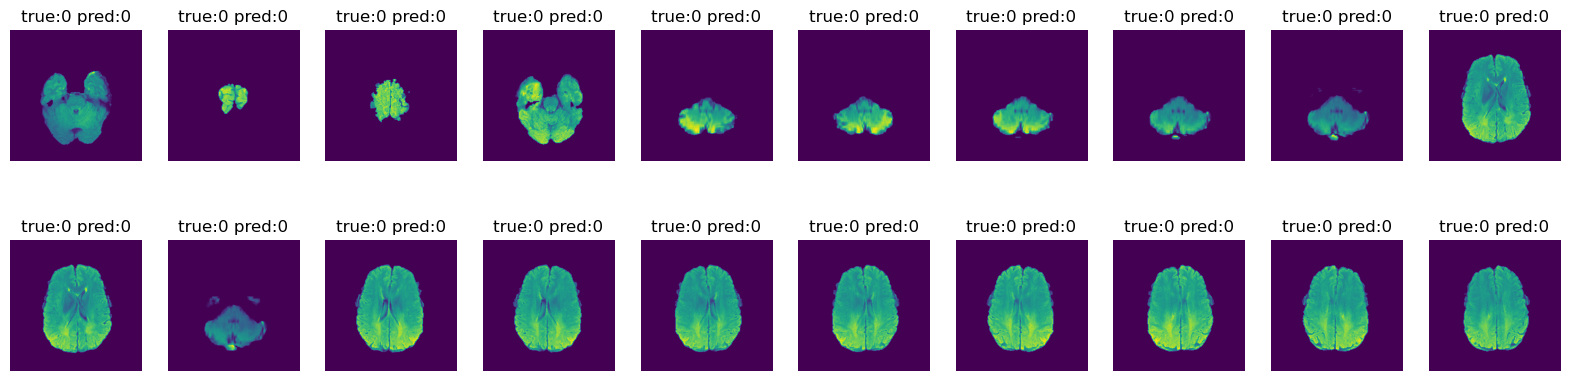

In [10]:
fig = plt.figure(figsize = (20,5))
data_block = torch.cat(data_list,dim = 0)
idx_list = [n for n,(x,y) in enumerate(zip(true_list,pred_list)) if x==y ]
len(idx_list)
for i,idx in enumerate(idx_list[:20]):
    ax = fig.add_subplot(2,10,1+i)
    ax.axis("off")
    ax.set_title(f'true:{true_list[idx]} pred:{pred_list[idx]}')
    ax.imshow(data_block[idx,0])

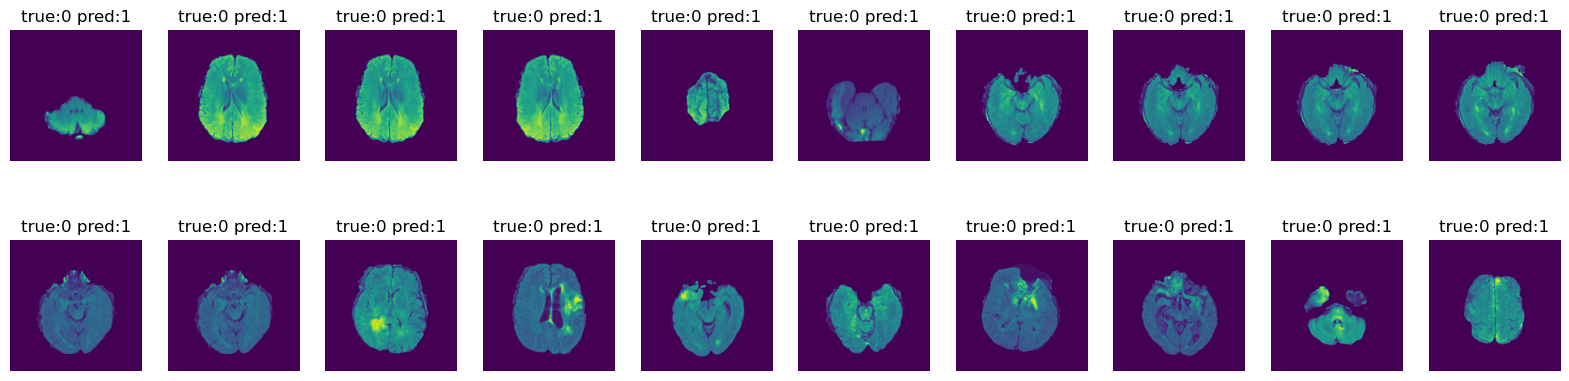

In [66]:
fig = plt.figure(figsize = (20,5))
data_block = torch.cat(data_list,dim = 0)
idx_list = [n for n,(x,y) in enumerate(zip(true_list,pred_list)) if x!=y ]
len(idx_list)
for i,idx in enumerate(idx_list[:20]):
    ax = fig.add_subplot(2,10,1+i)
    ax.axis("off")
    ax.set_title(f'true:{true_list[idx]} pred:{pred_list[idx]}')
    ax.imshow(data_block[idx,0])

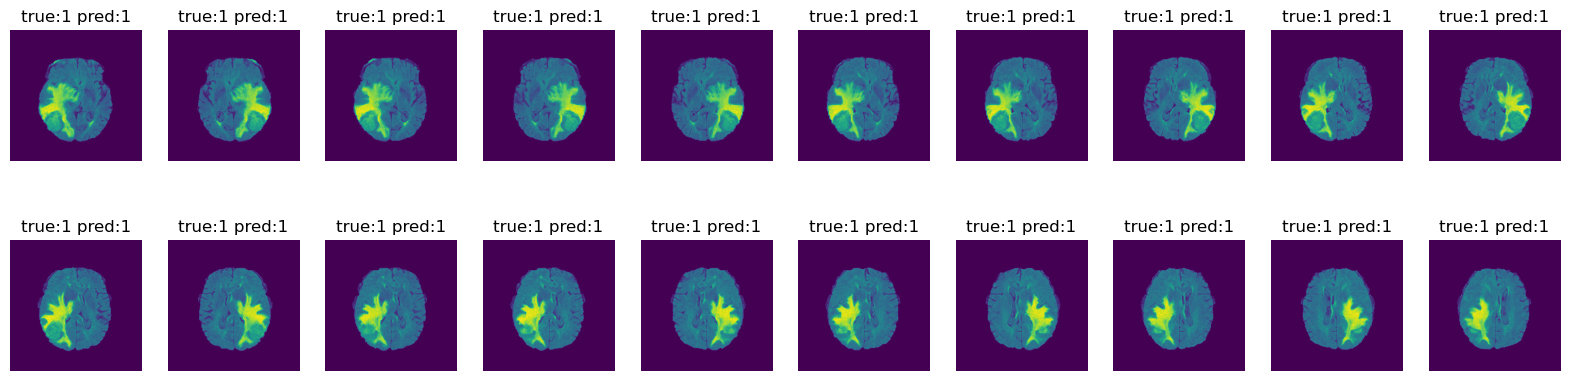

In [68]:
fig = plt.figure(figsize = (20,5))
data_block = torch.cat(data_list,dim = 0)
idx_list = [n for n,(x,y) in enumerate(zip(true_list,pred_list)) if x==y ]
len(idx_list)
for i,idx in enumerate(idx_list[-20:]):
    ax = fig.add_subplot(2,10,1+i)
    ax.axis("off")
    ax.set_title(f'true:{true_list[idx]} pred:{pred_list[idx]}')
    ax.imshow(data_block[idx,0])

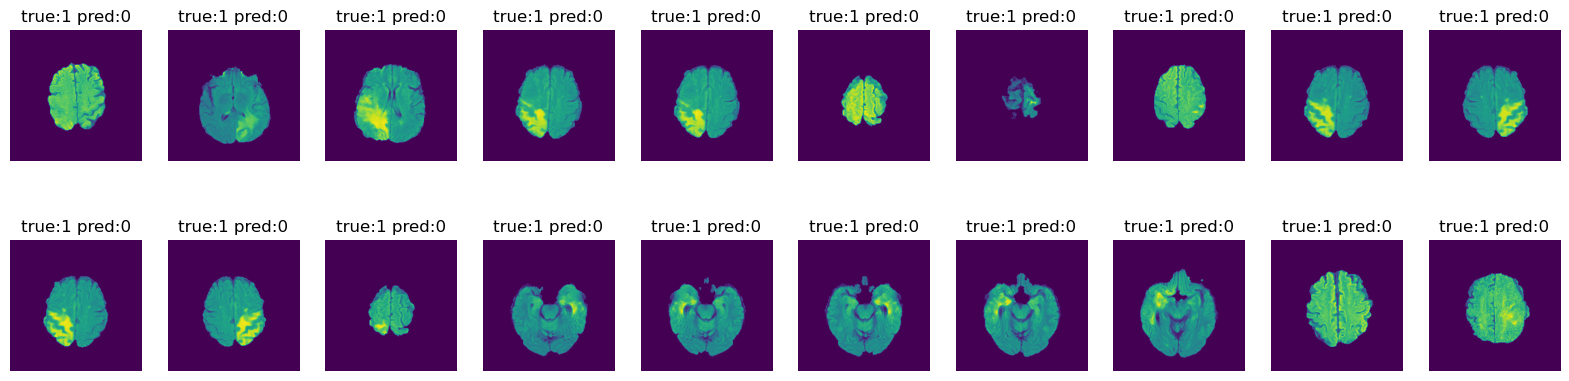

In [13]:
fig = plt.figure(figsize = (20,5))
data_block = torch.cat(data_list,dim = 0)
idx_list = [n for n,(x,y) in enumerate(zip(true_list,pred_list)) if x!=y ]
len(idx_list)
for i,idx in enumerate(idx_list[-20:]):
    ax = fig.add_subplot(2,10,1+i)
    ax.axis("off")
    ax.set_title(f'true:{true_list[idx]} pred:{pred_list[idx]}')
    ax.imshow(data_block[idx,0])